# Larmor motion in RZ coordinates in Warp
## Electrostatic/Magnetostatic Solvers Both on
### Current set to 10 uA, negligible effect over time period viewed on Larmor motion

In [1]:
%matplotlib notebook

In [2]:
import sys
sys.path.append('/Users/chall/research/github/rswarp/rswarp/utilities/')
import beam_analysis
import file_utils
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy import optimize

In [4]:
def svecplot(array):
    fig = plt.figure(figsize = (8,8))
    Q = plt.quiver(array[:,0],array[:,2],array[:,1],array[:,3])
    plt.quiverkey(Q,0.0, 0.92, 0.002, r'$2', labelpos='W')
    xmax = np.max(array[:,0])
    xmin = np.min(array[:,0])
    plt.xlim(1.5*xmin,1.5*xmax)
    plt.ylim(1.5*xmin,1.5*xmax)
    plt.show()

## Initial Distribution

In [5]:
f0 = file_utils.readparticles('diags/rz/hdf5/data00000001.h5')

In [6]:
step0 = beam_analysis.convertunits(f0['Electron'])


<IPython.core.display.Javascript object>


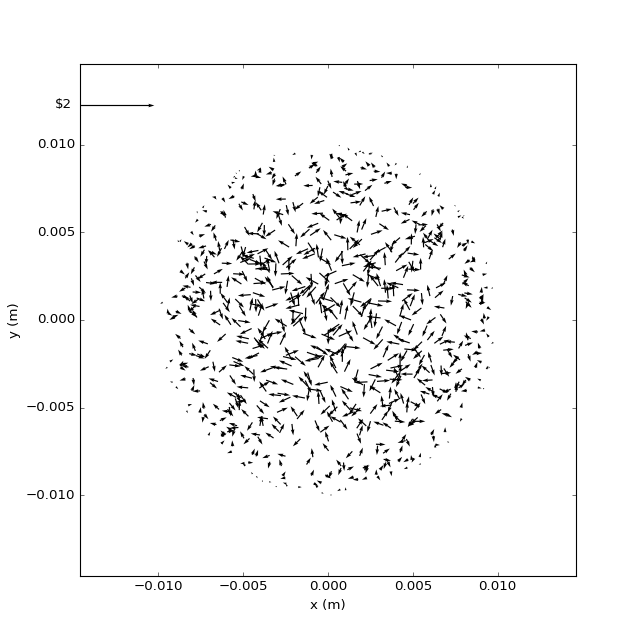

In [7]:
svecplot(step0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")

<IPython.core.display.Javascript object>


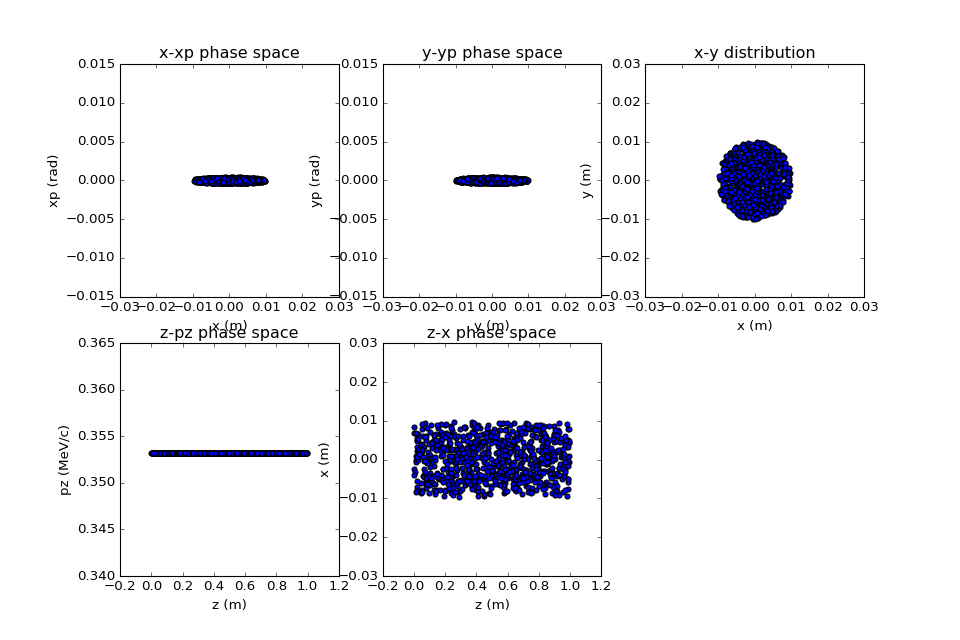

<IPython.core.display.Javascript object>


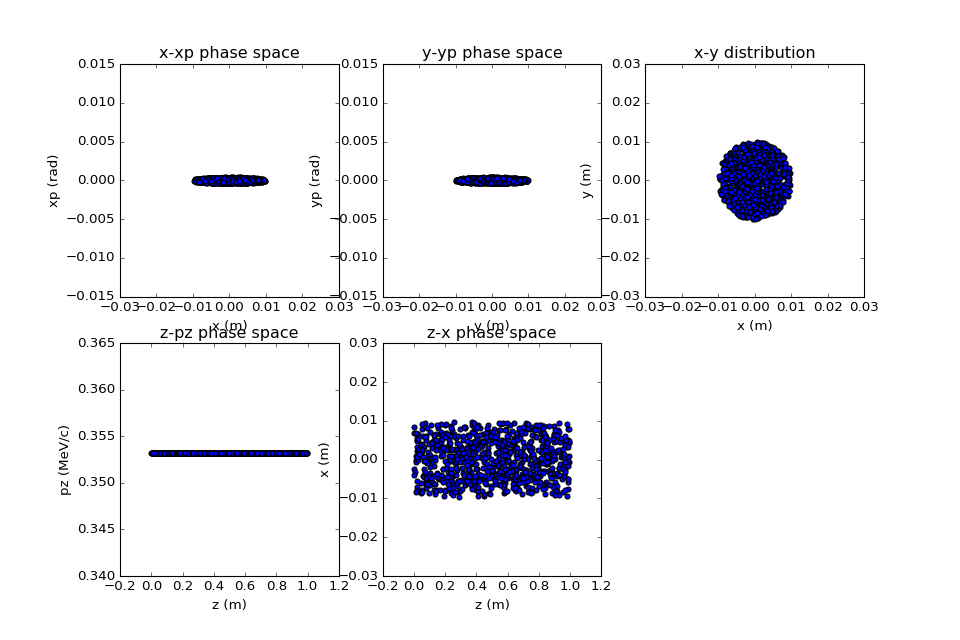

In [8]:
beam_analysis.plotphasespace(step0)

## All Steps

In [75]:
full =  file_utils.loadparticlefiles('diags/rz/hdf5/')

allSteps = []
allSteps2 = []
for step in range(100,5000,100):
    scon = beam_analysis.convertunits(full[step]['Electron'])
    allSteps.append(full[step]['Electron'])
allSteps = np.array(allSteps)
allSteps2 = np.array(allSteps2)

In [76]:
allSteps.shape

(49, 80000, 6)

<IPython.core.display.Javascript object>


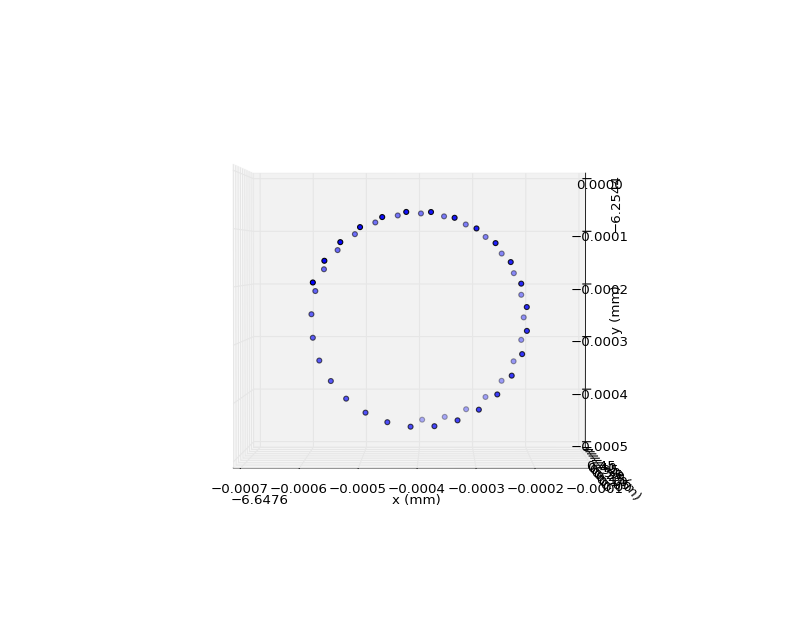

In [77]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(allSteps[:,8,0]*1e3,allSteps[:,8,4],allSteps[:,8,2]*1e3)

ax.set_xlabel('x (mm)')
ax.set_ylabel('z (m)')
ax.set_zlabel('y (mm)')


plt.show()

## Simple Method for finding gyrocenter and gyroradius (Deprecated)

### Assumes circle is well populated (many revolutions were observed in simulation period)

In [78]:
def findgyrostuff(array):
    #[turns,particle,dim]
    xmin = np.argmin(array[:,0])
    xmax = np.argmax(array[:,0])
    
    ymin = np.argmin(array[:,2])
    ymax = np.argmax(array[:,2])
    
    grho = (abs(array[ymax,2] - array[ymin,2]) + abs(array[xmax,0] - array[xmin,0])) / 4.
    gcen = ((array[ymax,0] + array[ymin,0]) / 2.,(array[xmax,2] + array[xmin,2]) / 2.)
    
    return grho, gcen
    
    
    

In [79]:
ptcl = 8

grho, gcen = findgyrostuff(allSteps[:,ptcl,:])
print grho, gcen

1.92318111658e-07 (-0.0066479956731200218, -0.0062546562403440475)


## Fitting Routine to Find Gyrocenter and Gyroradius

### Based on Example from SciPy Cookbook

In [80]:
def findR(x,y, xc, yc):
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f(c, x, y):
    R = findR(x, y, *c)
    return R - np.average(R)

def opt_circle(x,y):
    # coordinates of the barycenter
    x_m = np.average(x)
    y_m = np.average(y)
    ce = x_m, y_m
    center, ier = optimize.leastsq(f, ce, args=(x,y))
    xc, yc = center
    Ri = findR(x, y, *center)
    R = np.average(Ri)
    residual = np.sum((Ri - R)**2)
    return xc, yc, R, residual

In [81]:
lsqFit = opt_circle(allSteps[:,8,0],allSteps[:,8,2])
print "Values for particle %s:" % ptcl, lsqFit

Values for particle 8: (-0.0066479993040218007, -0.0062546611704507203, 1.9246241e-07, 8.1361535e-18)


<IPython.core.display.Javascript object>


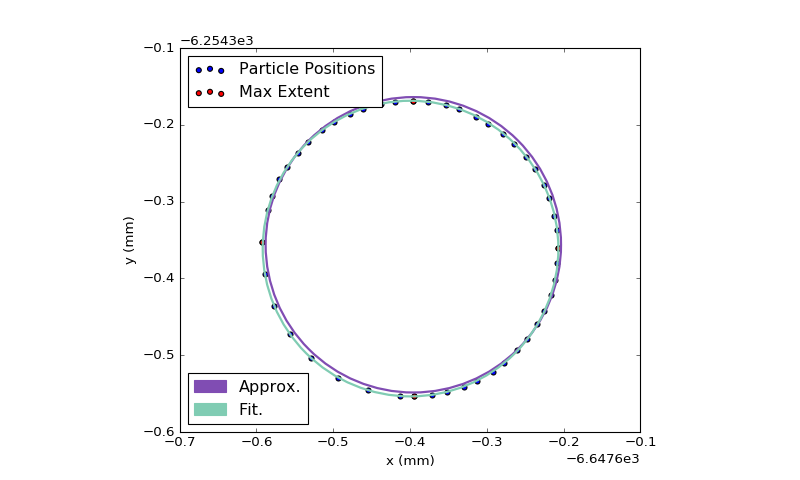

In [82]:
import matplotlib.patches as mpatches
figc = plt.figure(figsize=(10,6))
cx = plt.gca()
cx.scatter(allSteps[:,ptcl,0]*1e6,allSteps[:,ptcl,2]*1e6, label='Particle Positions')


xmin = np.argmin(allSteps[:,ptcl,0])
xmax = np.argmax(allSteps[:,ptcl,0])
ymin = np.argmin(allSteps[:,ptcl,2])
ymax = np.argmax(allSteps[:,ptcl,2])

cx.scatter(allSteps[xmin,ptcl,0]*1e6,allSteps[xmin,ptcl,2]*1e6,c='r', label='Max Extent')
cx.scatter(allSteps[xmax,ptcl,0]*1e6,allSteps[xmax,ptcl,2]*1e6,c='r')
cx.scatter(allSteps[ymin,ptcl,0]*1e6,allSteps[ymin,ptcl,2]*1e6,c='r')
cx.scatter(allSteps[ymax,ptcl,0]*1e6,allSteps[ymax,ptcl,2]*1e6,c='r')

ell = Ellipse(xy=(gcen[0]*1e6,gcen[1]*1e6), width=2*grho*1e6, height=2*grho*1e6, angle=0,label="Simple Optimizer",fill=False)
ell2 = Ellipse(xy=(lsqFit[0]*1e6,lsqFit[1]*1e6), width=2*lsqFit[2]*1e6, height=2*lsqFit[2]*1e6, angle=0,label="Full Optimizer",fill=False)

cx.add_artist(ell)
cx.add_artist(ell2)

ell.set_edgecolor((0.5,0.3,0.7))
ell.set_linewidth(2)

ell2.set_edgecolor((0.5,0.8,0.7))
ell2.set_linewidth(2)

appr_label = mpatches.Patch(color=(0.5,0.3,0.7), label='Approx.')
full_label = mpatches.Patch(color=(0.5,0.8,0.7), label='Fit.')

leg = plt.legend(handles=[appr_label,full_label],loc=3)
dx = plt.gca().add_artist(leg)

cx.legend(loc=2)
cx.set_xlabel('x (mm)')
cx.set_ylabel('y (mm)')

cx.set_aspect('equal')

plt.show()

In [22]:
def transverseP(array):
    c = 299792458
    me = 9.10938356e-31
    ptxn = array[1]* array[5]
    ptyn = array[3]* array[5]
    ptx = ptxn * 5.3442859e-22  # Convert from MeV/c to SI 
    pty = ptyn * 5.3442859e-22
    ptz = array[5] * 5.3442859e-22
    vz = c * ptz / np.sqrt(c**2*me**2 + ptz**2)
    gammaz = 1 / np.sqrt(1 - vz**2 / c**2) 
    vx = c * ptx / np.sqrt(c**2*me**2 + ptx**2) / gammaz
    vy = c * pty / np.sqrt(c**2*me**2 + pty**2) / gammaz
    
    return np.sqrt(vx**2 + vy**2)

In [27]:
ft = file_utils.readparticles('diags/rz/hdf5/data00000030.h5')
test = beam_analysis.convertunits(ft['Electron'])
vel = transverseP(test[8,:])
print vel

31127.0814327


In [28]:
def nrGR(B,v):
    # non-relativistic calculation
    
    p = 9.11e-31 * v
    e = 1.6e-19
    r = p / (e * B)
    return r

def relGR(B, v, vl):
    # radius with relativistic momentum
    
    vtot = np.sqrt(v**2 + vl**2)
    gamma = 1/np.sqrt(1-vtot**2/3e8**2)
    p = gamma * 9.11e-31 * v
    r = p / (1.6e-19 * B)
    return r

### Larmor radius without and with relativistic correction

In [29]:
print nrGR(1.0,vel), relGR(1.0,vel,170469000.0)

1.77229819907e-07 2.15380156905e-07


### Comparison of Larmor radius from simulation and calculated radius based on particle velocities read from simulation

In [30]:
print "Fractional Error with estimate:", 1 - relGR(1.0,vel,170469000.0) / grho 
print "Fractional Error with lst sq fit:", 1 - relGR(1.0,vel,170469000.0) / lsqFit[2], 

Fractional Error with estimate: -0.00358093855657
Fractional Error with lst sq fit: -0.00128107441256


# Fields

In [41]:
f0 = h5.File('diags/fields/electric/efield02000.h5', 'r')

Ex = f0['data/2000/meshes/E/r']
Ey = f0['data/2000/meshes/E/t']
Ez = f0['data/2000/meshes/E/z']

<IPython.core.display.Javascript object>


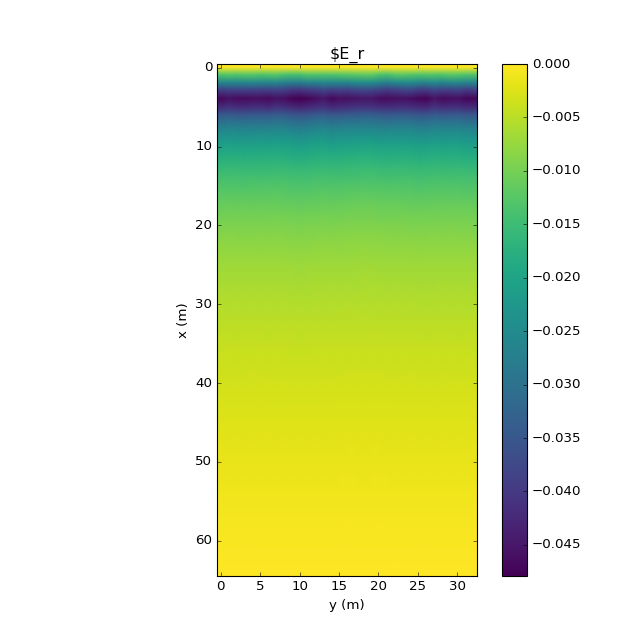

In [42]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
zslice = 10
ax.set_xlabel("y (m)")
ax.set_ylabel("x (m)")
ax.set_title("$E_r")
cax = ax.imshow(Ex[0,:,:],cmap=plt.cm.viridis)
fig.colorbar(cax)
plt.tight_layout
plt.show()